In [1]:
from preprocessing import preprocess_reference, preprocess_target, prepare_inputs, standardize_data
from dtw_utils import DTW_function, warp_function
from model import create_bnn_model, improved_penalized_nll
from evaluation import run_experiment, evaluate_non_warped


# Define file paths and parameters
wind_file = "./data_files/WI_H1_SWE_2017.csv"
dscovr_file = "./data_files/dsc_fc_summed_spectra_2017_v01.csv"
parameter = "Speed"  # Change this to "Density" or "Temperature" as needed
year = 2017

# Max value for the parameter
parameter_max_values = {
    "Speed": 850,
    "Density": 50,
    "Temperature": 120
}
max_value = parameter_max_values.get(parameter, 1)

# Define indices for training and evaluation
train_start, train_end = 0, 36000
eval_start, eval_end = 36000, 49000  # First month
future_month_indices = [
    (49000, 65000),  # Second month
    (65000, 81000)   # Third month
]

# Step 1: Preprocess data
reference_data = preprocess_reference(wind_file)
target_data = preprocess_target(dscovr_file)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
reference_data #Wind

,Speed,Temp,Density,bx,by,bz
Epoch_time,,,,,,
2017-01-01 00:00:00+00:00,551.3830,56.43920,6.909790,-6.232860,3.663370,-0.618211
2017-01-01 00:02:40+00:00,550.8905,55.48955,7.213100,-5.780820,-0.327115,-2.391585
2017-01-01 00:05:20+00:00,559.1935,52.77605,7.152890,-4.729515,-3.067300,-3.883065
2017-01-01 00:08:00+00:00,550.6040,55.52160,7.671590,-5.797990,-2.731430,-3.537750
2017-01-01 00:10:40+00:00,551.8050,53.21985,7.028765,-5.739440,-3.250100,-3.133550
...,...,...,...,...,...,...
2017-12-31 23:46:40+00:00,391.1725,44.63585,14.160100,2.752630,-3.058350,-7.148715
2017-12-31 23:49:20+00:00,389.2470,54.07950,16.266700,0.747070,-0.888578,-5.844250
2017-12-31 23:52:00+00:00,396.2290,40.92440,14.178350,3.068885,-2.336080,-7.139120


In [3]:
target_data #dscovr

,bx,by,bz,0,0.1,0.2,0.3,0.4,0.5,0.6,...,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30
t,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-5.951090,-1.709746,-3.241270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:02:40,-5.873180,-3.305190,-2.598700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:05:20,-5.737460,-3.549605,-2.038740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:08:00,-5.741180,-2.831990,-3.252300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:10:40,-5.658680,-2.894970,-3.115560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 23:46:40,4.976460,-4.971770,-5.477130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-31 23:49:20,2.926140,-3.184660,-6.830780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-31 23:52:00,2.161340,-1.924160,-3.708310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Wind and DSCOVR Bx time series pre-warping')

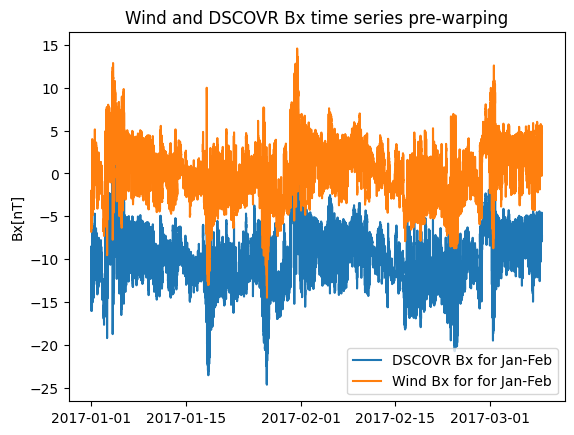

In [4]:
import matplotlib.pyplot as plt

plt.plot(target_data['bx'][0:36000]-10, label='DSCOVR Bx for Jan-Feb')
plt.plot(reference_data['bx'][0:36000], label='Wind Bx for for Jan-Feb')

plt.ylabel('Bx[nT]')
plt.legend()
plt.title('Wind and DSCOVR Bx time series pre-warping')

In [5]:
print(reference_data.columns)

Index(['Speed', 'Temp', 'Density', 'bx', 'by', 'bz'], dtype='object')


In [6]:
# Step 2: Dynamic Time Warping
query, template, alignment, indices = DTW_function(reference_data, target_data, parameter, train_start, train_end)


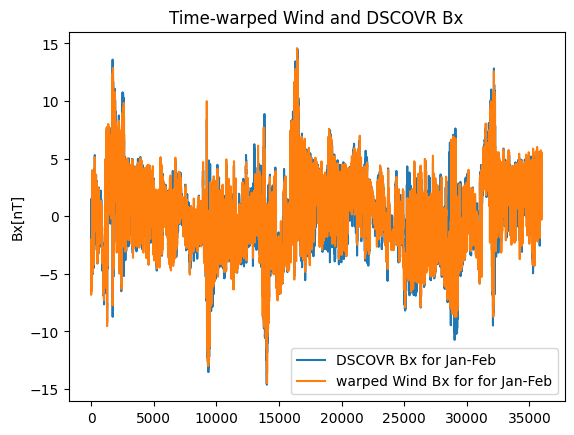

In [7]:
plt.plot(template, label='DSCOVR Bx for Jan-Feb')
plt.plot(query[indices], label='warped Wind Bx for for Jan-Feb')

plt.title('Time-warped Wind and DSCOVR Bx')
plt.legend()
#plt.plot(query2[ind2])
#plt.xlabel('time')
plt.ylabel('Bx[nT]')
plt.show()

In [8]:
warped_reference = warp_function(reference_data, indices, parameter)
warped_reference

array([551.383 , 550.8905, 559.1935, ..., 535.889 , 535.889 , 533.589 ])

In [9]:
# Step 3: Data Preparation for BNN
inputs_reference, outputs_target = prepare_inputs(target_data, warped_reference, train_start, train_end)

# Step 4: Standardize Data
#reference_train, target_train, reference_scaler, target_scaler = standardize_data(inputs_reference, outputs_target)

reference_scaler,  target_scaler, inputs_reference_scaled, outputs_target_scaled, reference_train, reference_test, target_train, target_test=standardize_data(inputs_reference, outputs_target) 


(25200, 50)
(25200, 1)
(10800, 50)
(10800, 1)


In [10]:
reference_train

array([[-0.22146493, -0.25879324, -0.3304261 , ..., -0.23439301,
        -0.22142102, -0.20396821],
       [-0.22146493, -0.25879324, -0.3304261 , ..., -0.23439301,
        -0.22142102, -0.20396821],
       [-0.22146493, -0.25879324, -0.3304261 , ..., -0.23439301,
        -0.22142102, -0.20396821],
       ...,
       [-0.22146493, -0.25879324, -0.3304261 , ..., -0.23439301,
        -0.22142102, -0.20396821],
       [-0.22146493, -0.25879324, -0.3304261 , ..., -0.23439301,
        -0.22142102, -0.20396821],
       [-0.22146493, -0.25879324, -0.3304261 , ..., -0.23439301,
        -0.22142102, -0.20396821]])

In [11]:
target_train

array([[-0.68678345],
       [-0.91199362],
       [ 0.44633386],
       ...,
       [ 0.181898  ],
       [-0.86589438],
       [-0.7575283 ]])

In [12]:
# Step 5: Create and Train BNN Model

num_epochs = 50
train_size=int(reference_train.shape[0])
input_shape = reference_train.shape[1:]

#bnn_model_full = create_bnn_model(train_size)
bnn_model_full_Jan_Feb= create_bnn_model(train_size)


run_experiment(bnn_model_full_Jan_Feb, reference_train, target_train,  max_value)


2024-11-24 14:12:13.915329: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 14:12:13.998681: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Training the model...
Epoch 1/50


2024-11-24 14:12:14.451026: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1260/1260 [==============================] - 5s 2ms/step - loss: 2.5172 - mae: 1.4606 - mse: 3.3631
Epoch 2/50
1260/1260 [==============================] - 3s 2ms/step - loss: 1.5823 - mae: 1.3136 - mse: 2.6955
Epoch 3/50
1260/1260 [==============================] - 2s 2ms/step - loss: 1.4673 - mae: 1.2105 - mse: 2.2518
Epoch 4/50
1260/1260 [==============================] - 2s 2ms/step - loss: 1.4333 - mae: 1.1559 - mse: 2.0491
Epoch 5/50
1260/1260 [==============================] - 3s 2ms/step - loss: 1.4220 - mae: 1.1526 - mse: 2.0358
Epoch 6/50
1260/1260 [==============================] - 2s 2ms/step - loss: 1.4126 - mae: 1.1317 - mse: 1.9689
Epoch 7/50
1260/1260 [==============================] - 2s 2ms/step - loss: 0.9783 - mae: 0.7745 - mse: 0.9956
Epoch 8/50
1260/1260 [==============================] - 3s 2ms/step - loss: 0.6685 - mae: 0.5499 - mse: 0.4876
Epoch 9/50
1260/1260 [==============================] - 3s 2ms/step - loss: 0.5035 - mae: 0.4629 - mse: 0.3553
Epoch 10/50


In [13]:
# Step 6: Evaluate First Month
Wind_input = evaluate_non_warped(reference_data, parameter)

DSCOVR_input_March, Wind_input_March = prepare_inputs(target_data, Wind_input, eval_start, eval_end)

query1_March, template_March, alignment_wd_March, ind_March=DTW_function(reference_data, target_data, parameter, eval_start, eval_end)

Wind_input_March_warped_=Wind_input_March[ind_March]


In [14]:
DSCOVR_input_March.shape

(13000, 50)

In [15]:
DSCOVR_input_March_final=reference_scaler.transform(DSCOVR_input_March)

In [16]:
prediction_distribution_March = bnn_model_full_Jan_Feb(DSCOVR_input_March_final)
prediction_mean_March = prediction_distribution_March.mean().numpy().tolist()
prediction_stdv_March = prediction_distribution_March.stddev().numpy()


Predictions_March_ = target_scaler.inverse_transform(prediction_mean_March)
Predictions_March_[0:5]

array([[537.44594722],
       [538.53850639],
       [533.86145564],
       [531.74169977],
       [529.07888077]])

In [17]:
prediction_stdv_March_=prediction_stdv_March*target_scaler.scale_

# The 95% CI is computed as mean ± (1.96 * stdv)
upper_March = (Predictions_March_ + (1.96 * prediction_stdv_March_)).tolist()
lower_March = (Predictions_March_ - (1.96 * prediction_stdv_March_)).tolist()
prediction_stdv_March_ = prediction_stdv_March_.tolist()


sample=10
    
for idx in range(sample):
    print(
        f"Prediction mean: {round(Predictions_March_[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv_March_[idx][0], 2)}, "
        f"95% CI: [{round(upper_March[idx][0], 2)} - {round(lower_March[idx][0], 2)}]"
        f" - Actual: {Wind_input_March_warped_[idx]}"
    )


Prediction mean: 537.45, stddev: 14.09, 95% CI: [565.06 - 509.83] - Actual: [533.774]
Prediction mean: 538.54, stddev: 14.14, 95% CI: [566.25 - 510.83] - Actual: [539.205]
Prediction mean: 533.86, stddev: 13.93, 95% CI: [561.16 - 506.56] - Actual: [539.0115]
Prediction mean: 531.74, stddev: 13.84, 95% CI: [558.86 - 504.62] - Actual: [530.7075]
Prediction mean: 529.08, stddev: 14.19, 95% CI: [556.9 - 501.26] - Actual: [534.096]
Prediction mean: 530.61, stddev: 14.03, 95% CI: [558.11 - 503.11] - Actual: [534.096]
Prediction mean: 528.7, stddev: 14.19, 95% CI: [556.5 - 500.89] - Actual: [530.0755]
Prediction mean: 523.93, stddev: 13.56, 95% CI: [550.51 - 497.35] - Actual: [531.854]
Prediction mean: 531.32, stddev: 13.8, 95% CI: [558.36 - 504.27] - Actual: [531.854]
Prediction mean: 533.55, stddev: 13.92, 95% CI: [560.83 - 506.27] - Actual: [537.5525]


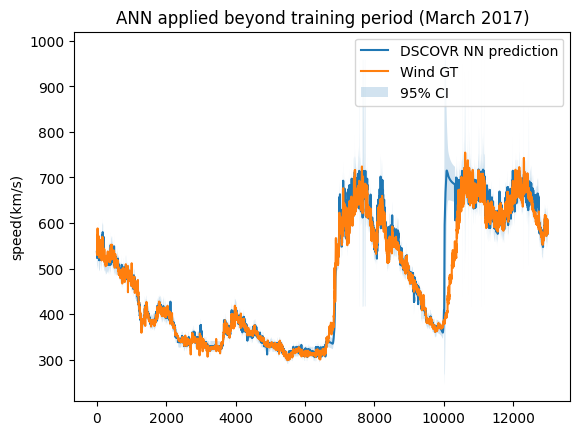

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the upper and lower bounds
upper_March_flat = np.ravel(upper_March)
lower_March_flat = np.ravel(lower_March)

# Plotting predictions
plt.plot(Predictions_March_, label='DSCOVR NN prediction')

# Plotting confidence interval
plt.fill_between(range(len(Predictions_March_)), upper_March_flat, lower_March_flat, alpha=0.2, label='95% CI')

# Plotting actual values
plt.plot(Wind_input_March_warped_, label='Wind GT')

plt.title(f"ANN applied beyond training period (March {year})")
plt.ylabel('speed(km/s)')
plt.legend()
#plt.savefig('CI_speed_March_DSCOVR_NN_prediction_and_Wind_GT_2017_2.png')
plt.show()


In [19]:
mask_March=(Predictions_March_ >= 1) & (Predictions_March_<=850)
Predictions_March=Predictions_March_[mask_March]
Wind_input_March_warped=Wind_input_March_warped_[mask_March]

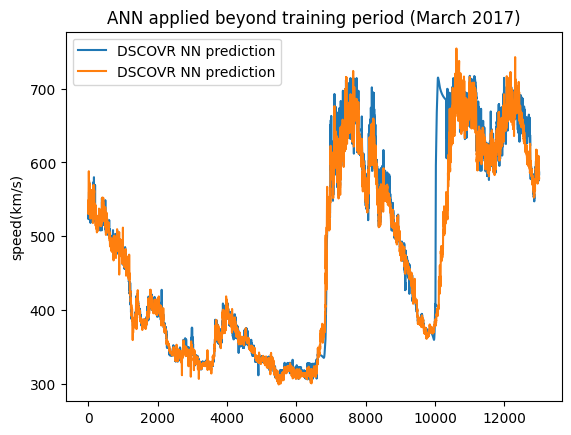

In [20]:
plt.plot(Predictions_March, label='DSCOVR NN prediction')
plt.plot(Wind_input_March_warped, label='DSCOVR NN prediction')
#plt.plot(Wind_input_March_warped, label='Wind GT')
plt.title(f"ANN applied beyond training period (March {year})")
#plt.savefig('speed_March_DSCOVR_NN_prediction_and_Wind GT_2017.png')
#plt.xlabel('')
plt.ylabel('speed(km/s)')
plt.legend()

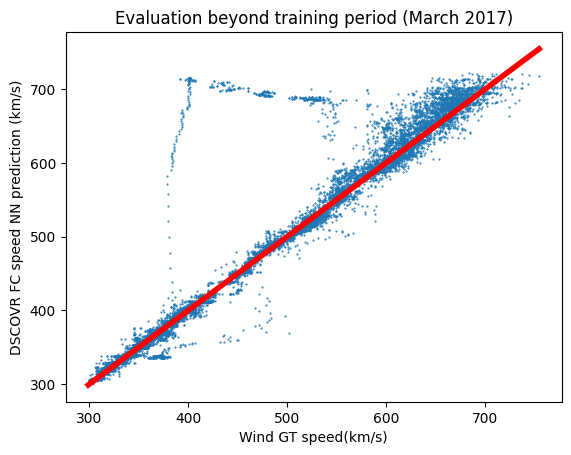

In [21]:
plt.plot(Wind_input_March_warped, Predictions_March, marker='.', markersize=1, linestyle = ' ')
plt.xlabel("Wind GT speed(km/s)")
plt.ylabel("DSCOVR FC speed NN prediction (km/s)")
plt.title(f"Evaluation beyond training period (March {year})")
#plt.xlim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
#plt.ylim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
plt.plot([np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped)],[np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped)], color='red', linewidth=4)
#plt.savefig('speed-March_prediction_2017.png')

# April

In [22]:
Wind_input_March_warped=Wind_input_March_warped.reshape(-1,1)
Wind_input_March_warped_final=target_scaler.transform(Wind_input_March_warped)

mask_March_flat = mask_March.flatten()

# Now use the flattened mask for indexing
DSCOVR_input_March_final = DSCOVR_input_March_final[mask_March_flat]

In [23]:
future_month_indices[0]

(49000, 65000)

In [24]:
# Step 6: Evaluate First Month
Wind_input = evaluate_non_warped(reference_data, parameter)

DSCOVR_input_April, Wind_input_April = prepare_inputs(target_data, Wind_input, future_month_indices[0][0], future_month_indices[0][1])

query1_April, template_April, alignment_wd_April, ind_April=DTW_function(reference_data, target_data, parameter, future_month_indices[0][0], future_month_indices[0][1])
Wind_input_April_warped_=Wind_input_April[ind_April]

In [25]:
DSCOVR_input_April_final=reference_scaler.transform(DSCOVR_input_April)

In [26]:
prediction_distribution_April = bnn_model_full_Jan_Feb(DSCOVR_input_April_final)
prediction_mean_April = prediction_distribution_April.mean().numpy().tolist()
prediction_stdv_April = prediction_distribution_April.stddev().numpy()


Predictions_April_ = target_scaler.inverse_transform(prediction_mean_April)
Predictions_April_

array([[577.41650189],
       [587.62229797],
       [588.51363047],
       ...,
       [375.59609137],
       [374.77914848],
       [374.09233996]])

In [27]:
prediction_stdv_April_=prediction_stdv_April*target_scaler.scale_

# The 95% CI is computed as mean ± (1.96 * stdv)
upper_April = (Predictions_April_ + (1.96 * prediction_stdv_April_)).tolist()
lower_April = (Predictions_April_ - (1.96 * prediction_stdv_April_)).tolist()
prediction_stdv_April_ = prediction_stdv_April_.tolist()


sample=10
    
for idx in range(sample):
    print(
        f"Prediction mean: {round(Predictions_April_[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv_April_[idx][0], 2)}, "
        f"95% CI: [{round(upper_April[idx][0], 2)} - {round(lower_April[idx][0], 2)}]"
        f" - Actual: {Wind_input_April_warped_[idx]}"
    )


Prediction mean: 577.42, stddev: 14.15, 95% CI: [605.14 - 549.69] - Actual: [585.007]
Prediction mean: 587.62, stddev: 14.2, 95% CI: [615.45 - 559.79] - Actual: [578.551]
Prediction mean: 588.51, stddev: 14.2, 95% CI: [616.35 - 560.68] - Actual: [575.441]
Prediction mean: 578.31, stddev: 14.15, 95% CI: [606.04 - 550.57] - Actual: [574.519]
Prediction mean: 579.02, stddev: 14.17, 95% CI: [606.79 - 551.25] - Actual: [572.29]
Prediction mean: 578.3, stddev: 14.16, 95% CI: [606.06 - 550.54] - Actual: [571.8505]
Prediction mean: 577.41, stddev: 14.13, 95% CI: [605.1 - 549.71] - Actual: [572.0925]
Prediction mean: 578.47, stddev: 14.14, 95% CI: [606.19 - 550.75] - Actual: [569.531]
Prediction mean: 577.84, stddev: 14.14, 95% CI: [605.55 - 550.14] - Actual: [572.5565]
Prediction mean: 576.69, stddev: 14.12, 95% CI: [604.37 - 549.01] - Actual: [572.5565]


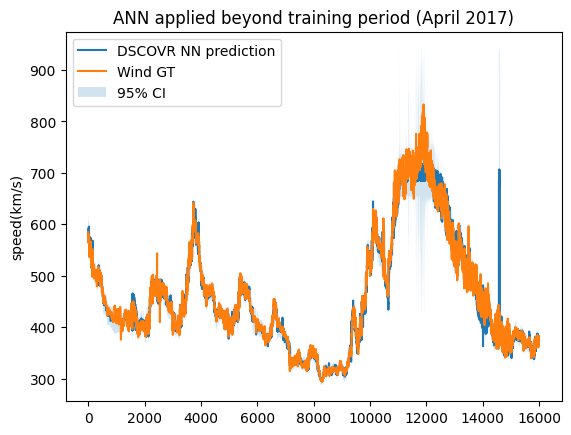

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the upper and lower bounds
upper_April_flat = np.ravel(upper_April)
lower_April_flat = np.ravel(lower_April)




# Plotting predictions
plt.plot(Predictions_April_, label='DSCOVR NN prediction')

# Plotting confidence interval
plt.fill_between(range(len(Predictions_April_)), upper_April_flat, lower_April_flat, alpha=0.2, label='95% CI')

# Plotting actual values
plt.plot(Wind_input_April_warped_, label='Wind GT')

plt.title(f"ANN applied beyond training period (April {year})")
plt.ylabel('speed(km/s)')
#plt.ylim(0,50)
plt.legend()
#plt.savefig('CI_speed_April_DSCOVR_NN_prediction_and_Wind_GT_2017.png')
plt.show()


In [29]:
mask_April=(Predictions_April_ >= 1) & (Predictions_April_<=850)
Predictions_April=Predictions_April_[mask_April]
Wind_input_April_warped=Wind_input_April_warped_[mask_April]

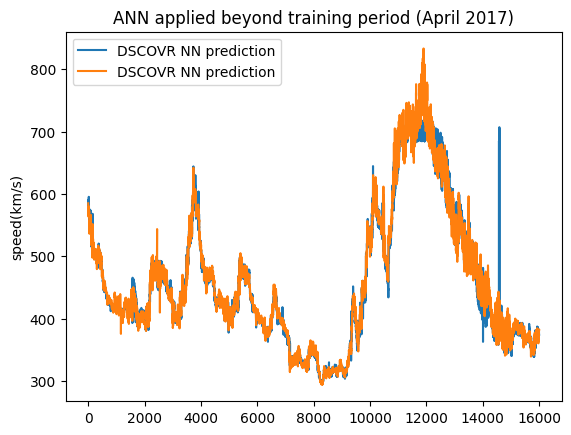

In [30]:
plt.plot(Predictions_April, label='DSCOVR NN prediction')
plt.plot(Wind_input_April_warped, label='DSCOVR NN prediction')
#plt.plot(Wind_input_March_warped, label='Wind GT')

plt.title(f"ANN applied beyond training period (April {year})")
#plt.savefig('speed_April_DSCOVR_NN_prediction_and_Wind GT_2017.png')
#plt.xlabel('')
plt.ylabel('speed(km/s)')
plt.legend()

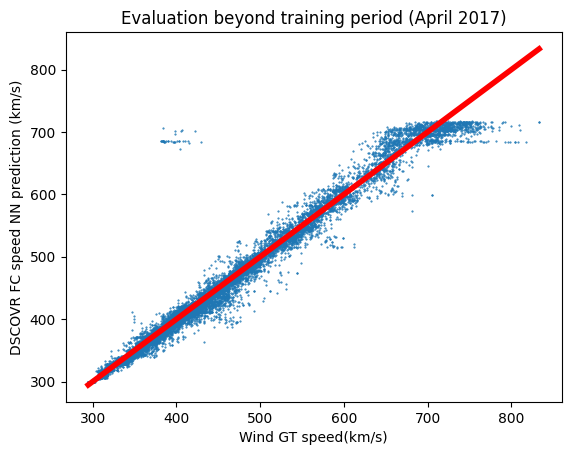

In [31]:
plt.plot(Wind_input_April_warped, Predictions_April, marker='.', markersize=1, linestyle = ' ')
plt.xlabel("Wind GT speed(km/s)")
plt.ylabel("DSCOVR FC speed NN prediction (km/s)")
plt.title(f"Evaluation beyond training period (April {year})")
#plt.xlim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
#plt.ylim(np.amin(Wind_input_March_warped), np.amax(Wind_input_March_warped))
plt.plot([np.amin(Wind_input_April_warped), np.amax(Wind_input_April_warped)],[np.amin(Wind_input_April_warped), np.amax(Wind_input_April_warped)], color='red', linewidth=4)
#plt.savefig('speed-March_prediction_2017.png')

Mean err %:  9.645742753928394
Median err %:  5.632244293854711
stddev: 19.531041981118804


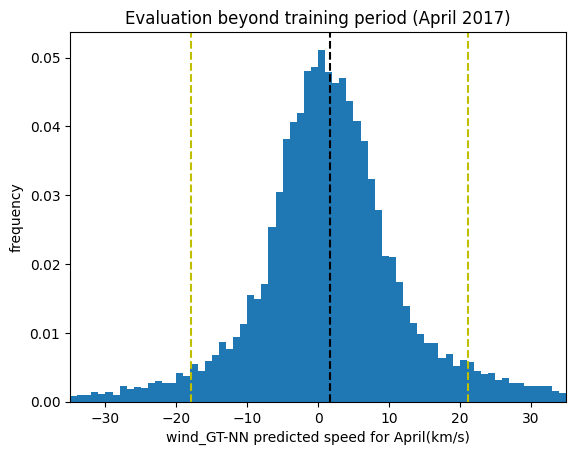

In [32]:
perr_NN_April = 100.*(Wind_input_April_warped-Predictions_April)/Wind_input_April_warped
tk_NN_April=np.where(Wind_input_April_warped > 0.1)
arr_perr_NN_April = (perr_NN_April)[tk_NN_April]
arr_regular_NN_April=(Wind_input_April_warped-Predictions_April)
m_NN_April=np.mean((arr_regular_NN_April))
sd_NN_April=np.std((arr_regular_NN_April))


plt.hist(arr_regular_NN_April, bins=np.arange(200)-100, density = 'true')

plt.axvline(m_NN_April, color='k', linestyle='dashed')
plt.axvline(m_NN_April+sd_NN_April, color='y', linestyle='dashed')
plt.axvline(m_NN_April-sd_NN_April, color='y', linestyle='dashed')

plt.xlim(-35,35)
#plt.yscale('log')
plt.title(f"Evaluation beyond training period (April {year})")
plt.xlabel('wind_GT-NN predicted speed for April(km/s)')
plt.ylabel('frequency')
#plt.savefig('Error-speed-April_prediction_2017.png')

print('Mean err %: ', np.mean(abs(arr_regular_NN_April)))
print('Median err %: ', np.median(abs(arr_regular_NN_April)))
#print('Most probable err %: ', np.mode(abs(arr_regular_NN_March)))

print('stddev:',sd_NN_April)